In [1]:
"""
导入必要的包
想完全重新运行需要删除pyscenic的相关文件
"""

import warnings

# import pyscenic #版本限制故在其他环境中安装
import seaborn as sns
import loompy as lp
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [51]:
# 设置参数
import matplotlib as mpl

mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

- 注意人类和小鼠

- 还可以自定义构建基因集


In [2]:
"""
准备数据集
当前数据集包含69249个细胞,已注释为22种细胞类型
由于考虑到批效应,我们将演示GRN方法只用于一个数据集,标记为s1d1(包含6224个细胞)
"""

'\n准备数据集\n当前数据集包含69249个细胞,已注释为22种细胞类型\n由于考虑到批效应,我们将演示GRN方法只用于一个数据集,标记为s1d1(包含6224个细胞)\n'

In [3]:
"""
加载完整数据集
"""

ANNO_COL = "manual_celltype_annotation"
adata = sc.read("./anndata_manual_anno.h5ad")
adata

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 100443 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_2', 'leiden_00_25', 'leiden_00_5', 'manual_celltype_anno

In [4]:
"""
使用GEX标签选择仅RNA特征,我这没得,全是RNA
"""

# adata.var["feature_types"]

rna = adata
del adata

rna.obs.batch.value_counts(), rna.obs.group.value_counts()

(GSM6685509    4890
 GSM6685520    4392
 GSM6685519    4363
 GSM6685496    4278
 GSM6685497    4264
 GSM6685498    4186
 GSM6685500    4141
 GSM6685501    4127
 GSM6685504    3996
 GSM6685499    3959
 GSM6685502    3836
 GSM6685526    3801
 GSM6685525    3782
 GSM6685503    3683
 GSM6685521    3507
 GSM6685505    3480
 GSM6685524    2990
 GSM6685513    2831
 GSM6685523    2737
 GSM6685515    2711
 GSM6685522    2662
 GSM6685518    2610
 GSM6685528    2309
 GSM6685517    2219
 GSM6685527    1978
 GSM6685510    1975
 GSM6685506    1877
 GSM6685514    1740
 GSM6685516    1691
 GSM6685507    1582
 GSM6685511    1450
 GSM6685512    1279
 GSM6685508    1117
 Name: batch, dtype: int64,
 Disorder    89472
 Normal      10971
 Name: group, dtype: int64)

In [5]:
rna.obs[["sample", "group"]].value_counts()

sample      group   
GSM6685509  Disorder    4890
GSM6685520  Disorder    4392
GSM6685519  Disorder    4363
GSM6685496  Disorder    4278
GSM6685497  Disorder    4264
GSM6685498  Disorder    4186
GSM6685500  Disorder    4141
GSM6685501  Disorder    4127
GSM6685504  Disorder    3996
GSM6685499  Disorder    3959
GSM6685502  Disorder    3836
GSM6685526  Disorder    3801
GSM6685525  Disorder    3782
GSM6685503  Disorder    3683
GSM6685521  Disorder    3507
GSM6685505  Disorder    3480
GSM6685524  Disorder    2990
GSM6685513  Disorder    2831
GSM6685523  Disorder    2737
GSM6685515  Normal      2711
GSM6685522  Disorder    2662
GSM6685518  Normal      2610
GSM6685528  Disorder    2309
GSM6685517  Normal      2219
GSM6685527  Disorder    1978
GSM6685510  Disorder    1975
GSM6685506  Disorder    1877
GSM6685514  Normal      1740
GSM6685516  Normal      1691
GSM6685507  Disorder    1582
GSM6685511  Disorder    1450
GSM6685512  Disorder    1279
GSM6685508  Disorder    1117
dtype: int64

In [6]:
rna.shape

(100443, 2000)

In [7]:
"""
这里选取高变量基因,以最小化下游计算需求
不设置HVGs也可以执行,但需要更多内存和时间
"""

sc.set_figure_params(facecolor="white")

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


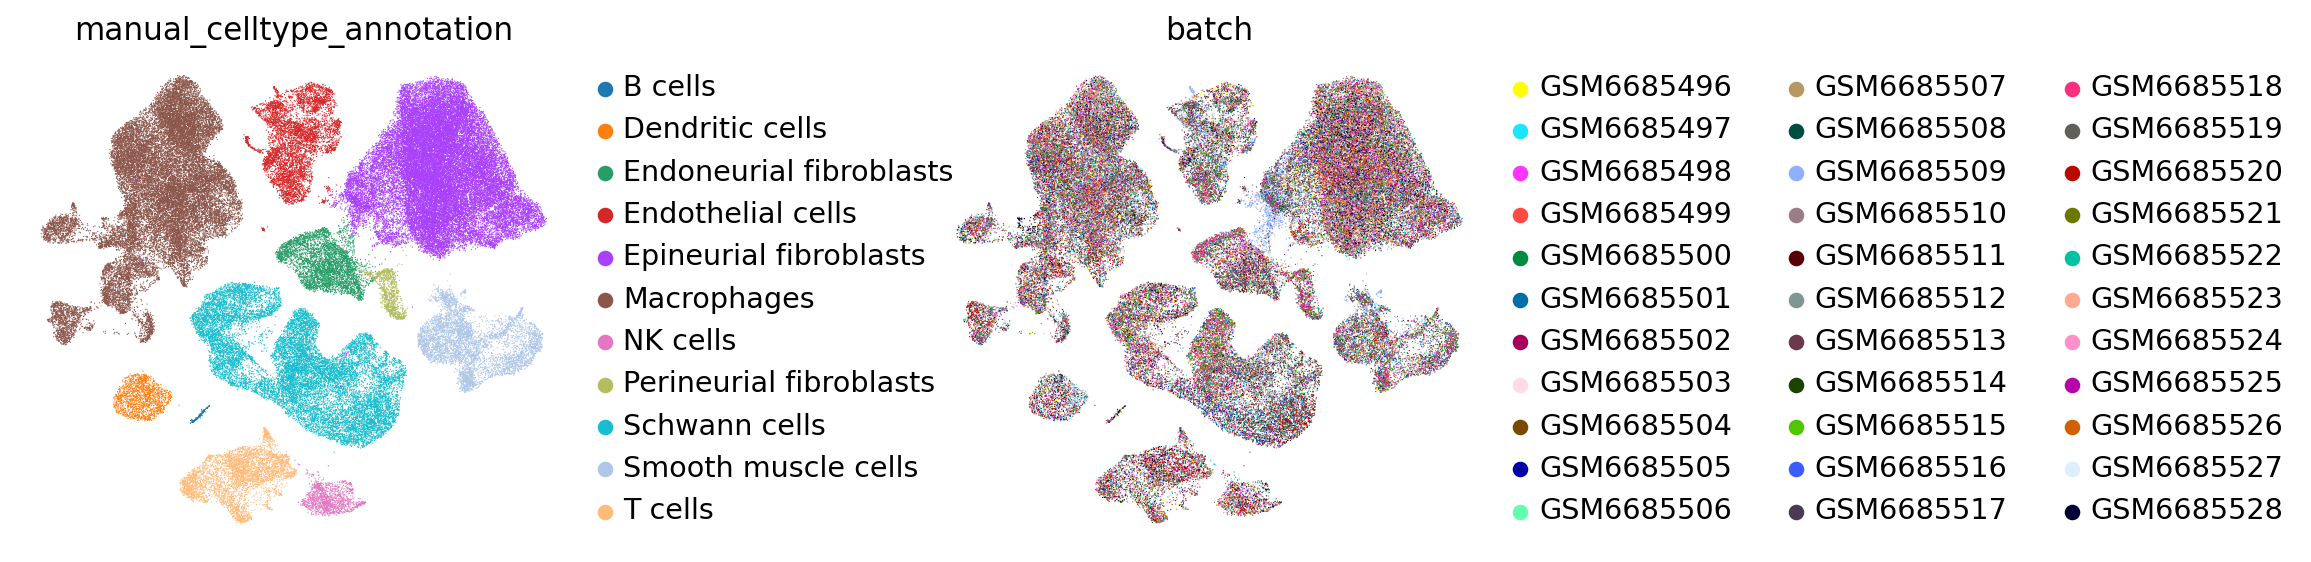

In [8]:
"""
这是所有供体细胞的基因表达数据嵌入图
可以看到供体主导细胞类型分组,未执行批效应校正
"""

sc.pl.embedding(
    rna,
    "X_umap",
    color=[ANNO_COL, "batch"],
    wspace=0.5,
    frameon=False,
    ncols=2,
)

In [9]:
"""
这里观察一个供体s1d1的细胞
对一个供体观察时,细胞可根据注释分类成簇
"""

rna.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,keep,RNA_snn_res.0.3,RNA_snn_res.0.6,RNA_snn_res.1,RNA_snn_res.1.2,seurat_clusters,...,size_factors,_scvi_batch,_scvi_labels,leiden,leiden_0_25,leiden_0_5,leiden_2,leiden_00_25,leiden_00_5,manual_celltype_annotation
AAACCTGAGGGCATGT-1_1,GSM6685496,13612.0,2694,3.364678,True,0,3,2,2,2,...,1.782377,0,0,0,0,0,15,0,0,Epineurial fibroblasts
AAACCTGAGTACACCT-1_1,GSM6685496,10047.0,2492,2.408679,True,0,0,2,5,5,...,1.587755,0,0,0,0,0,4,0,0,Epineurial fibroblasts
AAACCTGAGTACCGGA-1_1,GSM6685496,13943.0,3014,4.059385,True,0,4,3,16,16,...,2.133652,0,0,6,0,4,4,0,0,Epineurial fibroblasts
AAACCTGCAGCATGAG-1_1,GSM6685496,13575.0,2897,3.543278,True,0,0,1,2,2,...,1.905368,0,0,0,0,0,15,0,0,Epineurial fibroblasts
AAACCTGGTACTTGAC-1_1,GSM6685496,3416.0,1045,2.927400,True,6,7,18,21,21,...,0.466495,0,0,10,8,10,29,4,3,T cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACACTAAGTC-1_33,GSM6685528,2847.0,1269,1.685985,True,5,5,10,11,11,...,0.628226,32,0,8,4,6,31,3,4,Endothelial cells
TTTGTCACATGGGAAC-1_33,GSM6685528,3131.0,1267,9.134462,True,8,8,5,6,6,...,0.556062,32,0,7,7,8,14,2,2,Schwann cells
TTTGTCAGTCGAACAG-1_33,GSM6685528,8068.0,2319,3.532474,True,4,0,1,1,1,...,1.398253,32,0,2,0,0,1,0,0,Epineurial fibroblasts
TTTGTCATCAGAAATG-1_33,GSM6685528,6722.0,1805,3.049688,True,1,1,7,10,10,...,1.028753,32,0,18,1,2,23,1,1,Macrophages


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


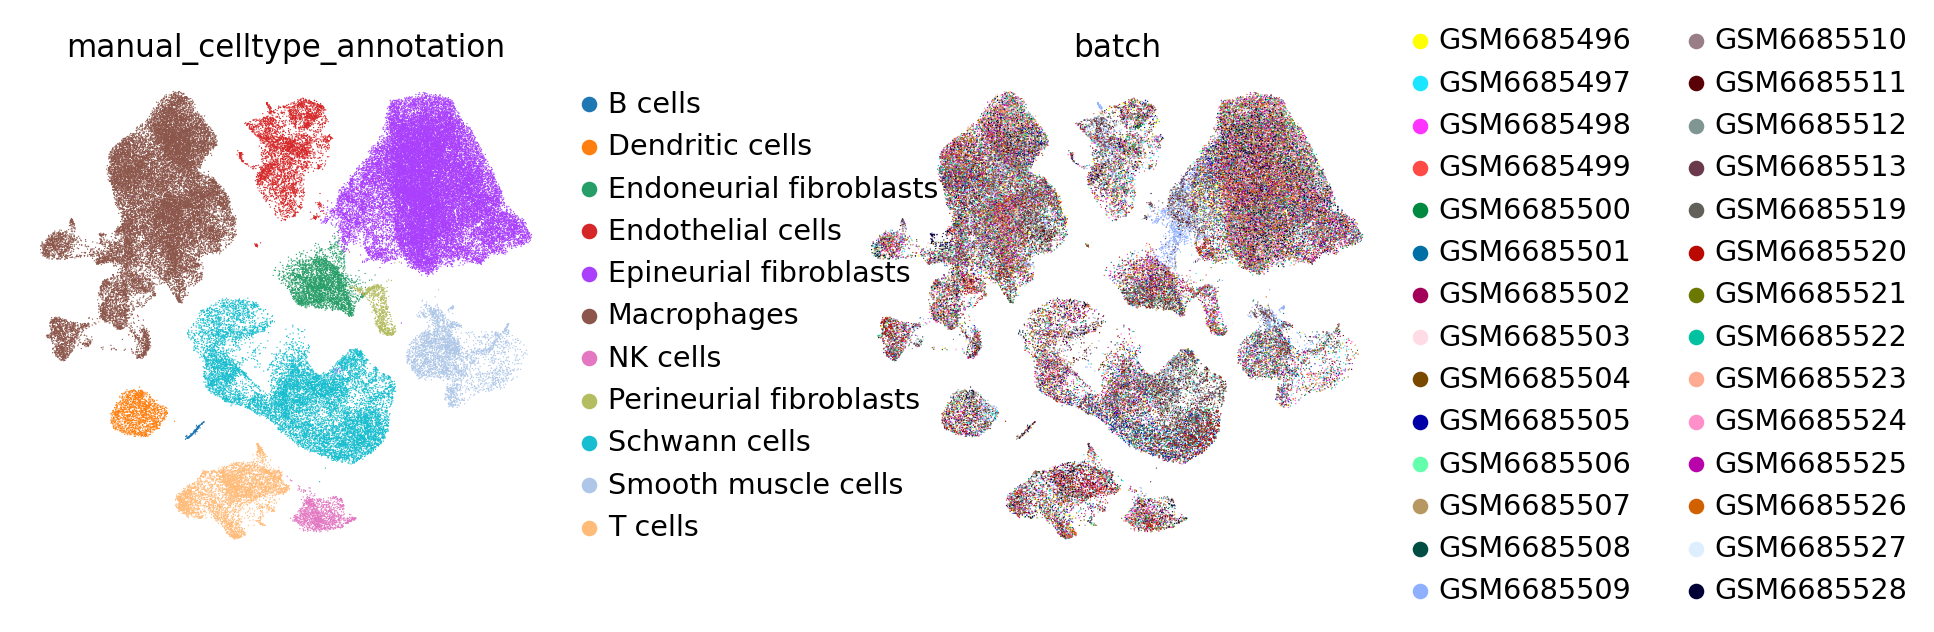

In [10]:
adata_batch = rna[rna.obs["group"] == "Disorder", :]
sc.pl.embedding(
    adata_batch,
    "X_umap",
    color=[ANNO_COL, "batch"],
    wspace=0.4,
    frameon=False,
    ncols=2,
)

In [11]:
"""
准备SCENIC

使用loompy,我们将基因表达值转换为loom文件
pyscenic需要这种文件格式作为输入
此外,allTFs_hg38.txt文件定义了与转录因子相关的基因符号列表
在加权这些基因与其他基因之间的关联时需要考虑
"""

'\n准备SCENIC\n\n使用loompy,我们将基因表达值转换为loom文件\npyscenic需要这种文件格式作为输入\n此外,allTFs_hg38.txt文件定义了与转录因子相关的基因符号列表\n在加权这些基因与其他基因之间的关联时需要考虑\n'

In [12]:
## 需要下载allTFs_hg38
import os
# # 清除代理
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""
# 文件的URL地址
# url = "https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt" 人类
url = "https://resources.aertslab.org/cistarget/tf_lists/allTFs_mm.txt" # mouse
# 下载目录
os.makedirs("pyscenic", exist_ok=True)
download_dir = "./pyscenic"

# 获取文件名（从URL的最后一部分）
filename = url.split("/")[-1]

# 完整的文件路径
filepath = os.path.join(download_dir, filename)

# 检查文件是否存在并且大小不为0
if not os.path.exists(filepath) or os.path.getsize(filepath) == 0:
    # 下载文件
    !wget -nc --directory-prefix=$download_dir $url

In [13]:
tfs_path = os.path.join(download_dir, filename)

In [14]:
loom_path = "pyscenic/neurips_processed_input.loom"
loom_path_output = "pyscenic/neurips_processed_output.loom"
tfs = [tf.strip() for tf in open(tfs_path)]

In [15]:
"""
验证被注释为TF的基因是否为提供输入数据的一部分
覆盖率不高,如50%或更多,可能是var中声明的特征名称问题,如EnSembl ID而不是gene_symbol
或者基因组是小鼠或大写风格与人类不同的其他物种,可能存在大小写差异
"""

# 通常的质控,检查对象是否有主要注释中的转录因子
print(
    f"%{np.sum(adata_batch.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%117 out of 1860 TFs are found in the object


In [16]:
"""
这里可以使用HVG或所有特征,通过将use_hvg设置为False来定义
"""

use_hvg = True
if use_hvg:
    mask = (adata_batch.var["highly_variable"] == True) | adata_batch.var.index.isin(
        tfs
    )
    adata_batch = adata_batch[:, mask]

In [17]:
"""
为NeurIPS供体创建loom文件
如果此步骤出错,请验证Gene/CellID等的标签是否正确定义
"""

row_attributes = {
    "Gene": np.array(adata_batch.var.index),
}
col_attributes = {
    "CellID": np.array(adata_batch.obs.index),
    "nGene": np.array(np.sum(adata_batch.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata_batch.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, adata_batch.X.transpose(), row_attributes, col_attributes)

In [18]:
"""
生成loom文件后,执行pyscenic推断TF与基因之间的关联
TF-基因关联由GRNBoost推断,并由TF与目标基因之间的定向权重汇总
该分析的输出是汇总所有报告关联及其重要性权重的表格
"""

'\n生成loom文件后,执行pyscenic推断TF与基因之间的关联\nTF-基因关联由GRNBoost推断,并由TF与目标基因之间的定向权重汇总\n该分析的输出是汇总所有报告关联及其重要性权重的表格\n'

In [19]:
"""
下面的一些步骤需要指明核心数量(num_workers)
按可用计算资源增加
"""

num_workers = 60

In [20]:
# adjacencies 输出文件
outpath_adj = "pyscenic/adj.csv"

In [21]:
if not os.path.exists(outpath_adj) or os.path.getsize(outpath_adj) == 0:
    !/home/fanxi/miniconda3/envs/pyscenic/bin/pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers}
    
# TODO: 在外面切换了一个环境运行

In [22]:
"""
显示TF-target associations的顶部
"""

results_adjacencies = pd.read_csv("pyscenic/adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 203717


,TF,target,importance
0,Wisp2,Gpx3,975.164907
1,Wisp2,Gas6,897.044099
2,Irf7,Ifi27l2b,834.983476
3,Prdx5,Pla2g7,778.077542
4,Irf7,Mx2,724.524339


In [23]:
"""
可视化权重分布用于概览pyscenic获得的分位数和阈值
pyscenic grn步骤提供,重要性得分遵循单峰分布
负/正值表示重要性较少/较多的TF-基因关联
从该分布的右尾,我们可以恢复最相关的TF与潜在目标基因的交互作用,这是基因表达值和pyscenic分析所支持的
"""

'\n可视化权重分布用于概览pyscenic获得的分位数和阈值\npyscenic grn步骤提供,重要性得分遵循单峰分布\n负/正值表示重要性较少/较多的TF-基因关联\n从该分布的右尾,我们可以恢复最相关的TF与潜在目标基因的交互作用,这是基因表达值和pyscenic分析所支持的\n'

(-10.0, 10.0)

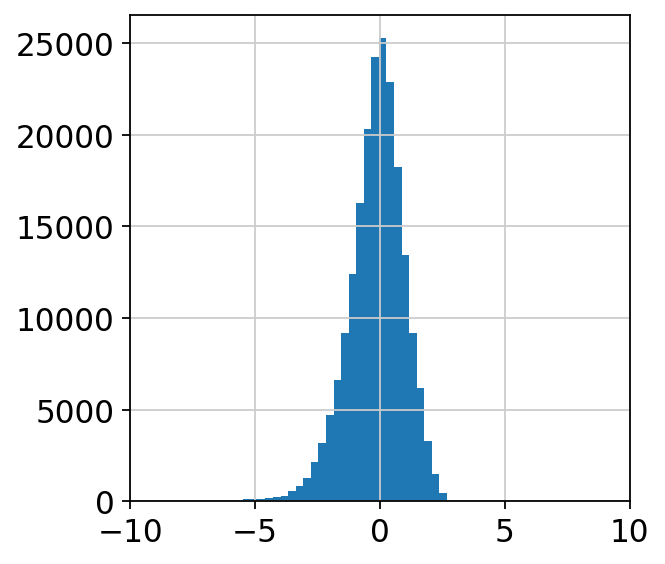

In [24]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

In [25]:
"""
由于目标基因在启动子上具有DNA结合位点(特异性DNA结合位点),可以将这些与TF关联
接下来,我们使用TF与转录起始位点(TSS)的注释来精炼此注释
"""

'\n由于目标基因在启动子上具有DNA结合位点(特异性DNA结合位点),可以将这些与TF关联\n接下来,我们使用TF与转录起始位点(TSS)的注释来精炼此注释\n'

In [26]:
"""
下载Aerts实验室预计算的TSS注释
"""

'\n下载Aerts实验室预计算的TSS注释\n'

In [27]:
# 文件URL

## 人类
# url = "https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather"

## 小鼠
url = "https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc9nr/gene_based/mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather"
# 下载目录
download_dir = "./pyscenic" 

# 获取文件名
filename = url.split("/")[-1]

# 完整路径 
filepath = os.path.join(download_dir, filename)

# 检查文件
if not os.path.exists(filepath) or os.path.getsize(filepath) == 0:
    # 下载
    !wget -nc --directory-prefix=$download_dir $url

In [28]:
import glob
import os

# ranking databases
db_glob = "pyscenic/*feather"
db_names = " ".join(glob.glob(db_glob))

In [29]:
"""
下载motif-TF关联目录
"""

'\n下载motif-TF关联目录\n'

In [30]:
# URL

## 人类
# url = "https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

## 小鼠
url = "https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.mgi-m0.001-o0.0.tbl"

# 下载目录
download_dir = "./pyscenic"

# 文件名
filename = url.split("/")[-1]

# 路径
filepath = os.path.join(download_dir, filename)

# 检查文件
if not os.path.exists(filepath) or os.path.getsize(filepath) == 0:
    # 下载
    !wget -nc --directory-prefix=$download_dir $url

In [31]:
filepath

'./pyscenic/motifs-v9-nr.mgi-m0.001-o0.0.tbl'

In [32]:
# motif databases
# motif_path = "pyscenic/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
motif_path = filepath

In [33]:
"""
使用motif和启动子基因关联的目录,检索先前关联的子集
这一步在普通硬件上可能需要几分钟
"""

'\n使用motif和启动子基因关联的目录,检索先前关联的子集\n这一步在普通硬件上可能需要几分钟\n'

In [34]:
if not os.path.exists('pyscenic/reg.csv')or os.path.getsize('pyscenic/reg.csv') == 0:
    !/home/fanxi/miniconda3/envs/pyscenic/bin/pyscenic ctx pyscenic/adj.csv \
        {db_names} \
        --annotations_fname {motif_path} \
        --expression_mtx_fname {loom_path} \
        --output pyscenic/reg.csv \
        --mask_dropouts \
        --num_workers {num_workers} > pyscenic/pyscenic_ctx_stdout.txt

In [35]:
"""
建议按照相对贡献排名或视觉定义的高信噪比阈值的分位数来探索候选项
"""

'\n建议按照相对贡献排名或视觉定义的高信噪比阈值的分位数来探索候选项\n'

In [36]:
"""
定义自定义分位数用于进一步探索
"""

'\n定义自定义分位数用于进一步探索\n'

In [37]:
import numpy as np

n_genes_detected_per_cell = np.sum(adata_batch.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.50, 1]
)
print(percentiles)

0.01     56.0
0.05    104.0
0.10    139.0
0.50    220.0
1.00    623.0
dtype: float64


In [38]:
"""
直方图显示每个细胞检测到的基因分布
这有助于下一步定义参数 --auc_threshold
具体地说,--auc_threshold的默认参数是0.05,在该图中,这将选择大约144个基因,以用作每个细胞的AUCell计算的参考
修改此参数会影响估计的AUC值
"""

'\n直方图显示每个细胞检测到的基因分布\n这有助于下一步定义参数 --auc_threshold\n具体地说,--auc_threshold的默认参数是0.05,在该图中,这将选择大约144个基因,以用作每个细胞的AUCell计算的参考\n修改此参数会影响估计的AUC值\n'

/tmp/ipykernel_394967/825804311.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")


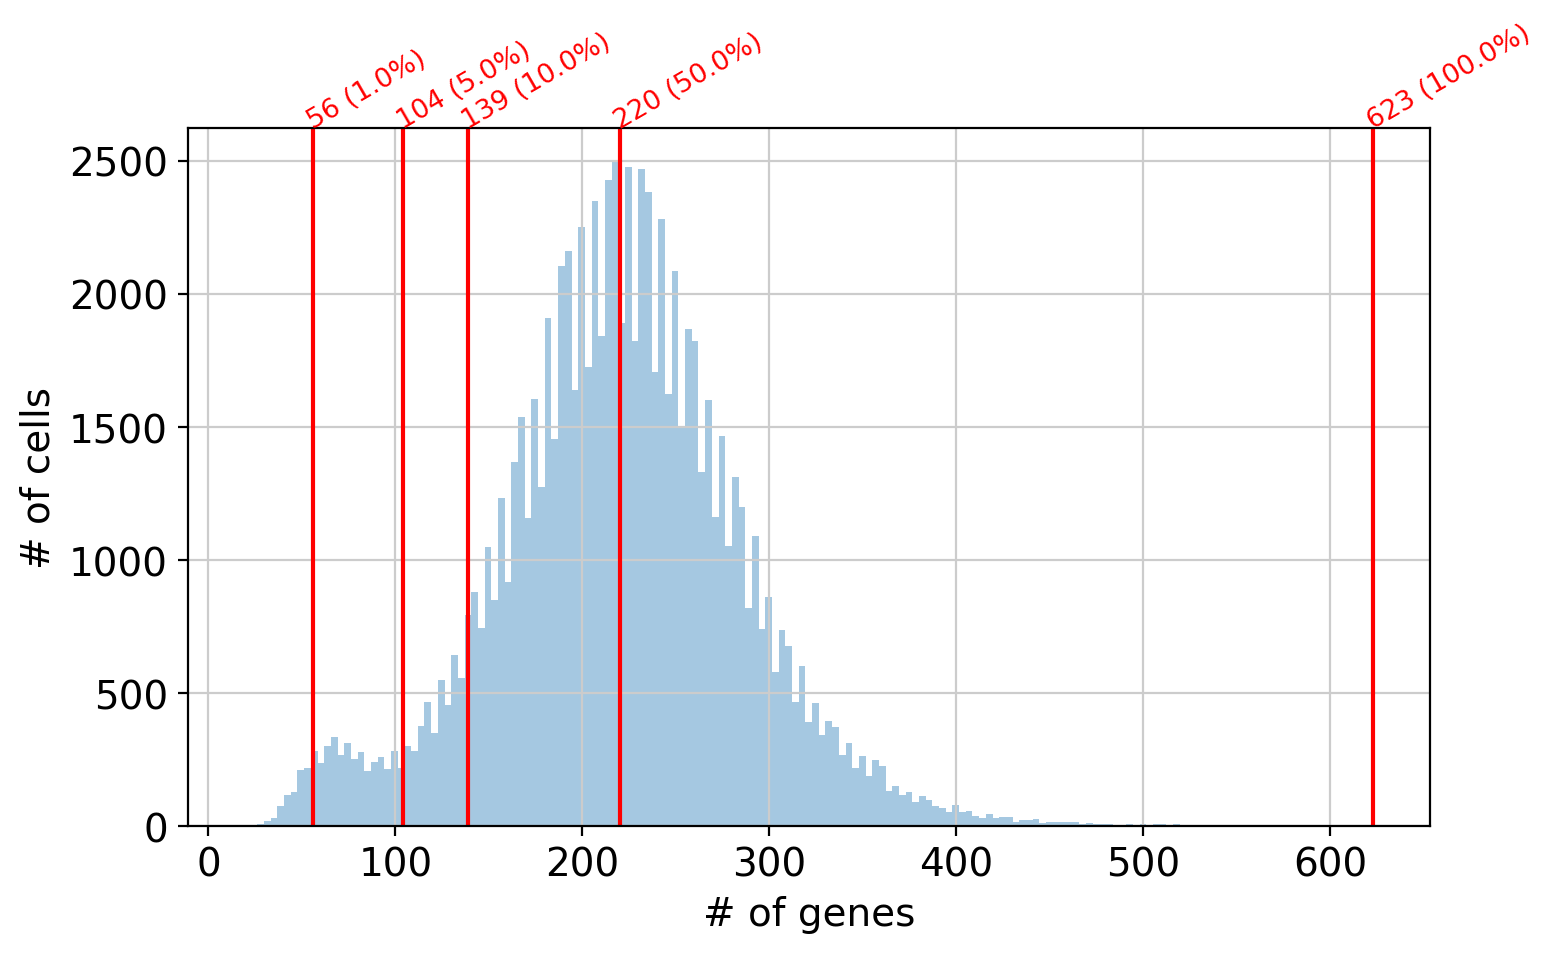

In [39]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

In [40]:
"""
这一步将使用转录因子计算曲线下面积值,它总结了在每个细胞中观察到的基因表达与上述因子调控的目标基因之间的关联程度

使用上面生成的单元x Tf矩阵和这些分数,我们可以只使用这些分数来计算新的嵌入
"""

auc_hold = 0.05  # 默认是0.05

In [41]:
"""
要想重新修改的阈值生效,需要删除之前生成的文件
"""
# TODO:重新计算需删除loom_path_output
if os.path.exists(loom_path_output):
    os.remove(loom_path_output)

if not os.path.exists(loom_path_output) or os.path.getsize(loom_path_output) == 0:
    !/home/fanxi/miniconda3/envs/pyscenic/bin/pyscenic aucell $loom_path \
        pyscenic/reg.csv \
        --auc_threshold {auc_hold} \
        --output {loom_path_output} \
        --num_workers {num_workers} > pyscenic/pyscenic_aucell_stdout.txt


2024-06-21 14:28:22,045 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-06-21 14:28:24,869 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2024-06-21 14:28:25,917 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2024-06-21 14:28:36,276 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [42]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [46]:
import anndata as ad


ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
# sc.tl.tsne(ad_auc_mtx) # TODO tsne 需要修复

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [47]:
"""
基于Tf-regulons和auc_mtx生成的可视化数据
"""

adata_batch.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
# adata_batch.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

/tmp/ipykernel_394967/1661266312.py:4: ImplicitModificationWarning: Setting element `.obsm['X_umap_aucell']` of view, initializing view as actual.
  adata_batch.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


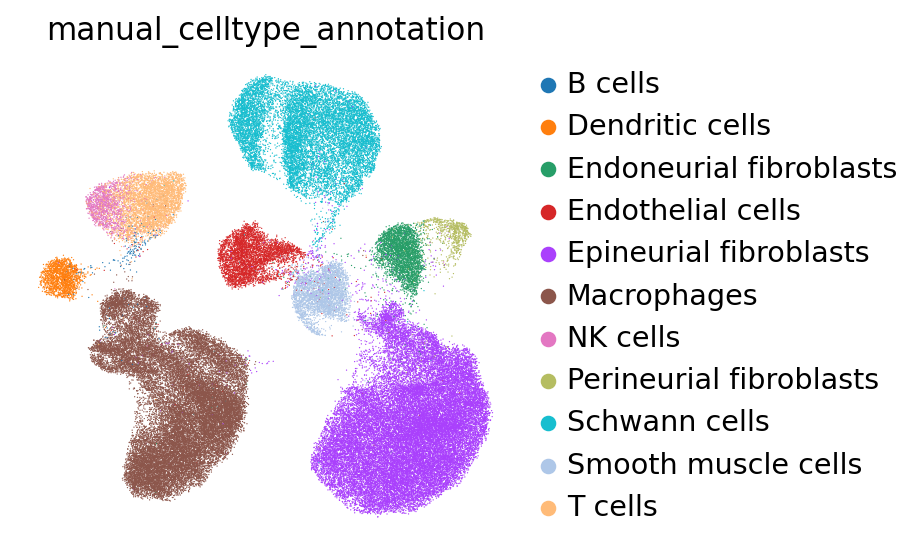

In [60]:
"""
UMAP可视化确认来自scenic的信号能够捕获将大多数细胞群分裂为亚群的规则
因此,信息tf调控子可以实现细胞类型的识别
"""

## 删除空的分类，可能没必要
adata_batch.obs[ANNO_COL] = adata_batch.obs[ANNO_COL].cat.remove_unused_categories()

sc.pl.embedding(
    adata_batch,
    basis="X_umap_aucell",
    color=ANNO_COL,
    # edges=True,
    # add_outline=True,
    save="10-UMAP-pyscenic-TF调控因子实现细胞类型的识别.pdf",
)

In [50]:
"""
SCENIC生成的tSNE可视化也确认这种对大多数细胞类型的细胞类型分离
"""

# sc.pl.embedding(
#     adata_batch, basis="X_tsne_aucell", color="celltypist_cell_label_coarse"
# )

'\nSCENIC生成的tSNE可视化也确认这种对大多数细胞类型的细胞类型分离\n'

In [61]:
"""
结果解释
"""

auc_mtx[ANNO_COL] = adata_batch.obs[ANNO_COL]
mean_auc_by_cell_type = auc_mtx.groupby(ANNO_COL).mean()
mean_auc_by_cell_type.to_csv("./table/10-pyscenic-mean_auc_by_cell_type.csv")
mean_auc_by_cell_type

,Bach2(+),Bcl11a(+),Bhlhe22(+),Cebpa(+),Cebpd(+),Crem(+),E2f2(+),Egr2(+),Egr4(+),Erg(+),...,Sox8(+),Sox9(+),Spi1(+),Spib(+),Spic(+),Sry(+),Tbx21(+),Tgif1(+),Traf4(+),Vdr(+)
manual_celltype_annotation,,,,,,,,,,,,,,,,,,,,,
B cells,0.039274,0.031779,0.008758,0.051394,0.025825,0.037242,0.100339,0.017538,0.003729,0.028504,...,0.004236,0.002361,0.042772,0.061060,0.049349,0.008456,0.052612,0.013486,0.033248,0.033441
Dendritic cells,0.040492,0.078678,0.006486,0.054661,0.019074,0.026744,0.102306,0.017713,0.001562,0.034471,...,0.002928,0.001440,0.045954,0.088593,0.060358,0.029993,0.035411,0.011660,0.088938,0.044460
Endoneurial fibroblasts,0.020095,0.006784,0.190890,0.019743,0.124686,0.011251,0.002700,0.023130,0.023042,0.029483,...,0.140994,0.072132,0.023346,0.009798,0.017580,0.000269,0.001019,0.003389,0.002629,0.010368
Endothelial cells,0.012903,0.011858,0.047820,0.025098,0.052898,0.017834,0.009925,0.020431,0.002683,0.069348,...,0.012229,0.023316,0.026529,0.015660,0.027138,0.000769,0.005735,0.011935,0.004128,0.014150
Epineurial fibroblasts,0.010372,0.002113,0.037821,0.018864,0.126826,0.010286,0.007952,0.020339,0.082010,0.024542,...,0.033111,0.019032,0.020085,0.006337,0.016583,0.000218,0.002422,0.004092,0.001376,0.010550
Macrophages,0.034764,0.014564,0.014665,0.071109,0.025439,0.018338,0.056179,0.014478,0.000703,0.025041,...,0.009454,0.002238,0.060153,0.030478,0.051853,0.030274,0.017543,0.009909,0.006532,0.038068
NK cells,0.030618,0.030621,0.007548,0.045982,0.019738,0.057014,0.104053,0.019848,0.006451,0.025833,...,0.002787,0.001201,0.042321,0.043554,0.036847,0.005911,0.133021,0.031346,0.010975,0.032466
Perineurial fibroblasts,0.009058,0.012808,0.115264,0.021050,0.102993,0.009397,0.010937,0.028193,0.011594,0.033854,...,0.083214,0.048725,0.022105,0.011589,0.020662,0.000171,0.002690,0.009991,0.000922,0.007573
Schwann cells,0.036083,0.028745,0.015709,0.022490,0.037303,0.006646,0.002170,0.071323,0.005659,0.028618,...,0.015812,0.027815,0.024804,0.009494,0.019504,0.002320,0.002232,0.006138,0.001470,0.006528


In [62]:
"""
用颜色显示前N个TF调控因子
"""

top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

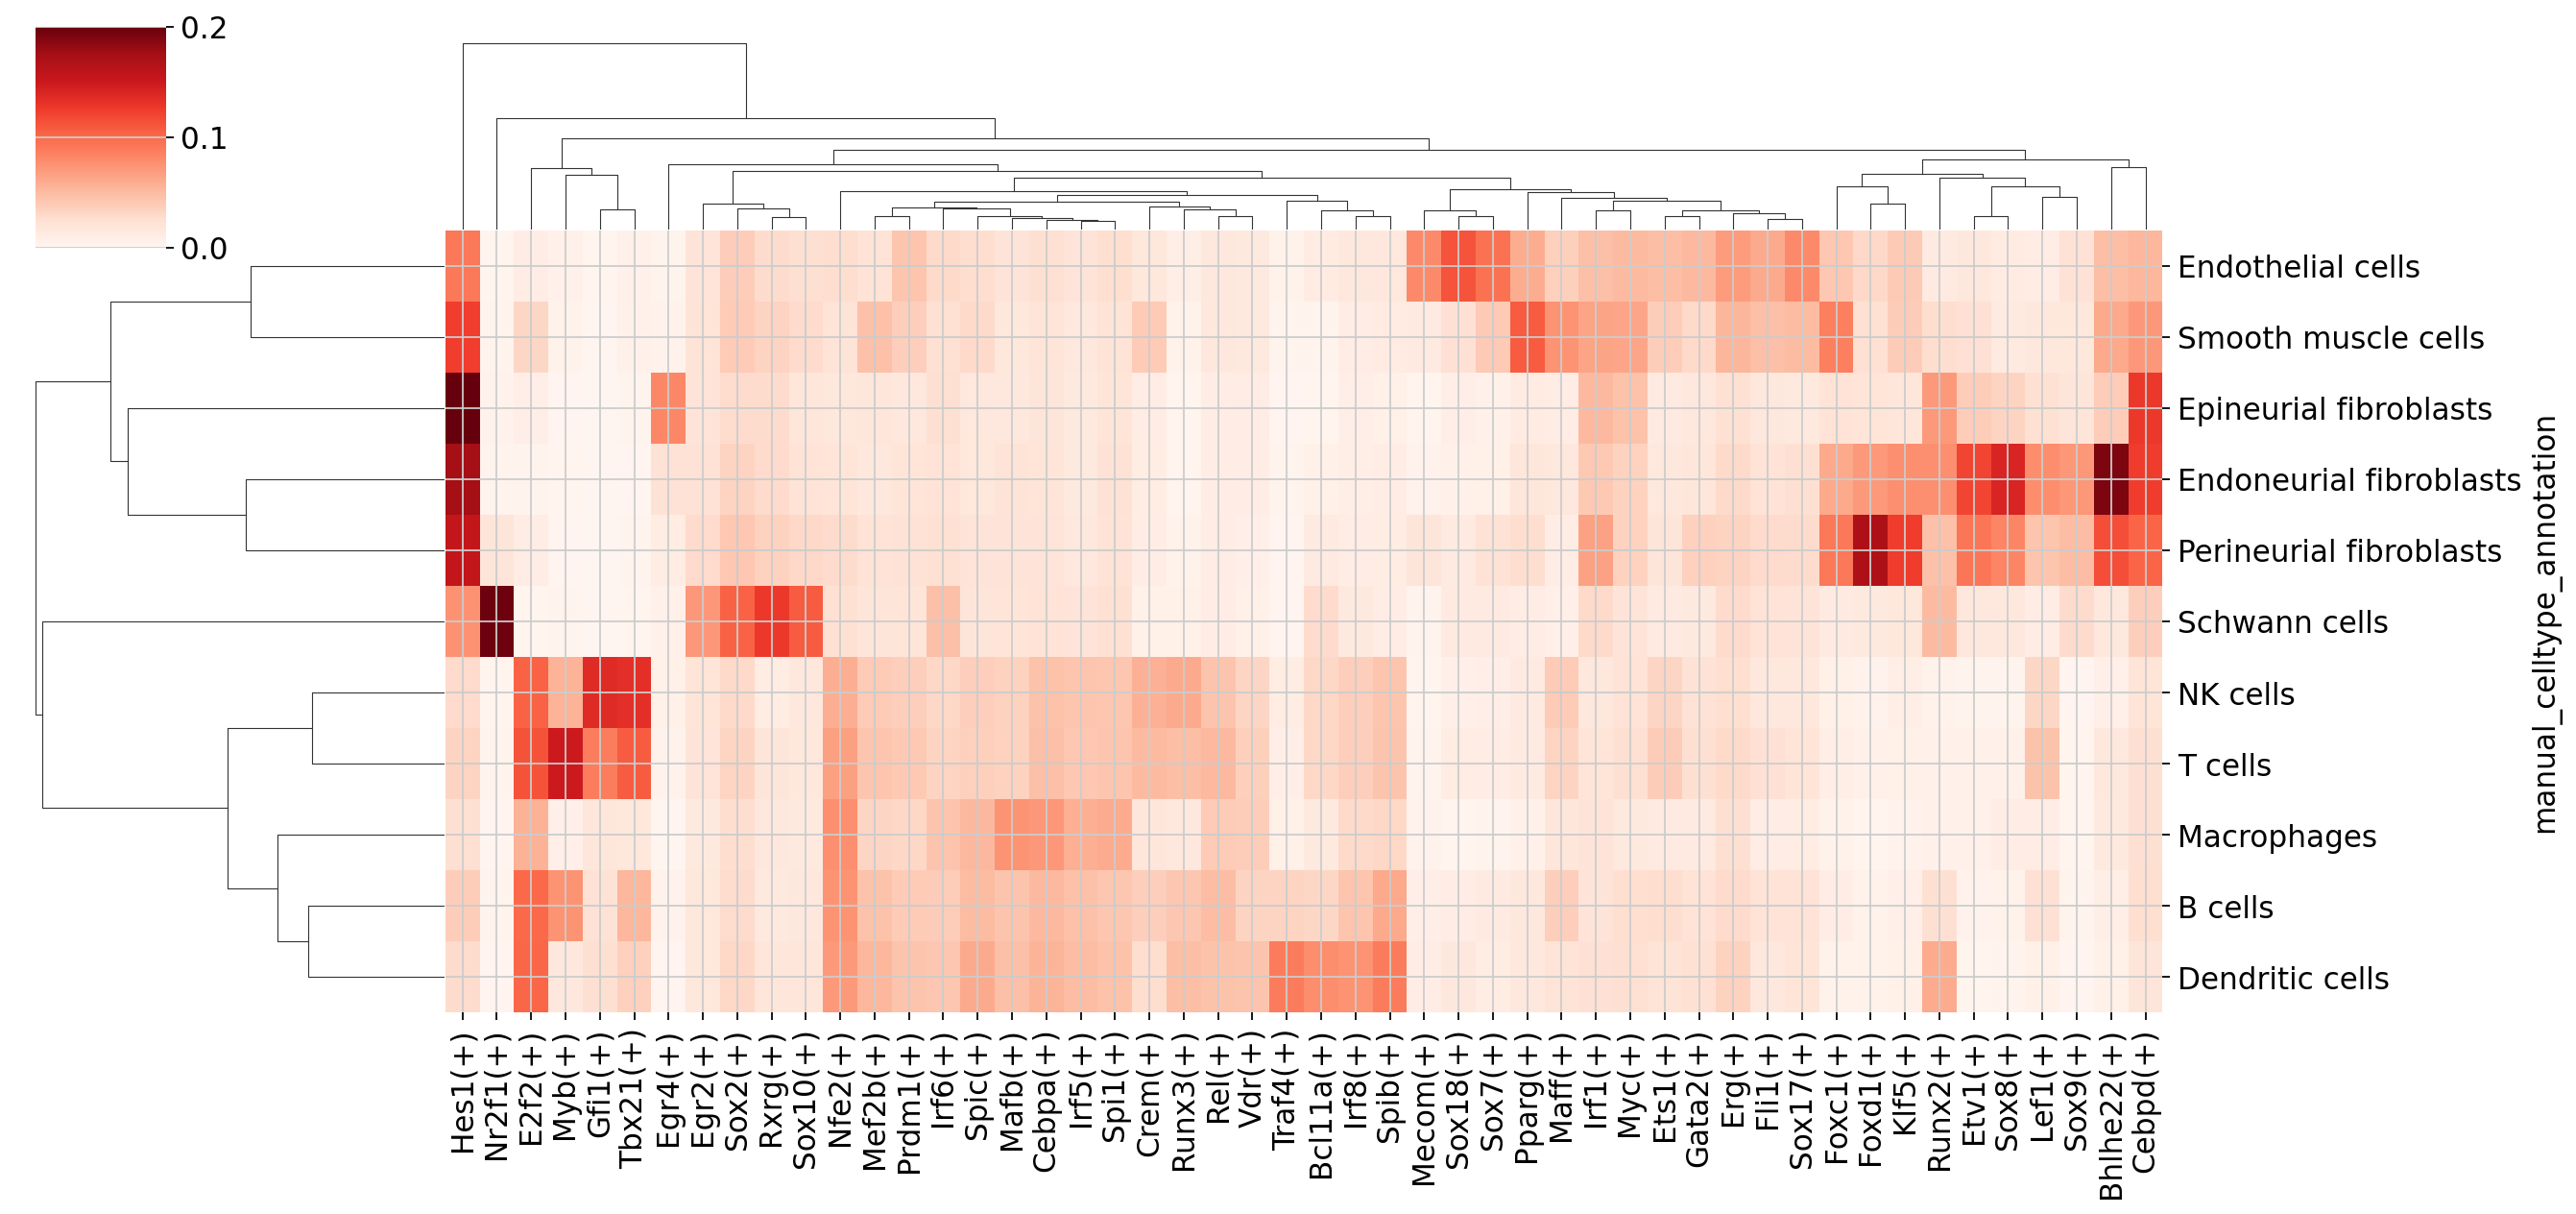

In [108]:
"""
一旦我们知道了我们正在研究的生物系统中涉及的顶级TF-调节因子,我们可以根据每个TF的每细胞评分或每个细胞类型解释的TF的总体AUC(下面的蓝色热图)来检查估计的活动。
"""

g = sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[17, 8],  # Adjust the figure size as needed
    cmap="Reds",  # Change the colormap to 'Reds'
    vmin=0,
    vmax=0.2,
    xticklabels=True,
    yticklabels=True,
    # dendrogram_ratio=(0.02, 0),  # Adjust these values to change dendrogram size
)


# 保存图像
g.savefig("figures/10-pyscenic-mean_auc_by_cell_type_top_50.pdf")

# 如果需要显示图像，可以使用plt.show()
plt.show()

In [73]:
"""
由于热图表明一些TF与特定细胞类型密切相关,我们可以验证它们的表达水平作为额外验证
这是通过匹配我们想要突出显示的TF名称来完成的,并使用Scanpy可视化这些名称(红色热图)
"""

tf_names = top_tfs.index.str.replace(r"\(\+\)", "", regex=True)

adata_batch_top_tfs = adata_batch[:, adata_batch.var_names.isin(tf_names)]

In [79]:
adata_batch_top_tfs

View of AnnData object with n_obs × n_vars = 89472 × 50
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_2', 'leiden_00_25', 'leiden_00_5', 'manual_celltype

In [90]:
sc.tl.dendrogram(adata_batch_top_tfs, use_rep="HARMONY", groupby=ANNO_COL)

Storing dendrogram info using `.uns['dendrogram_manual_celltype_annotation']`


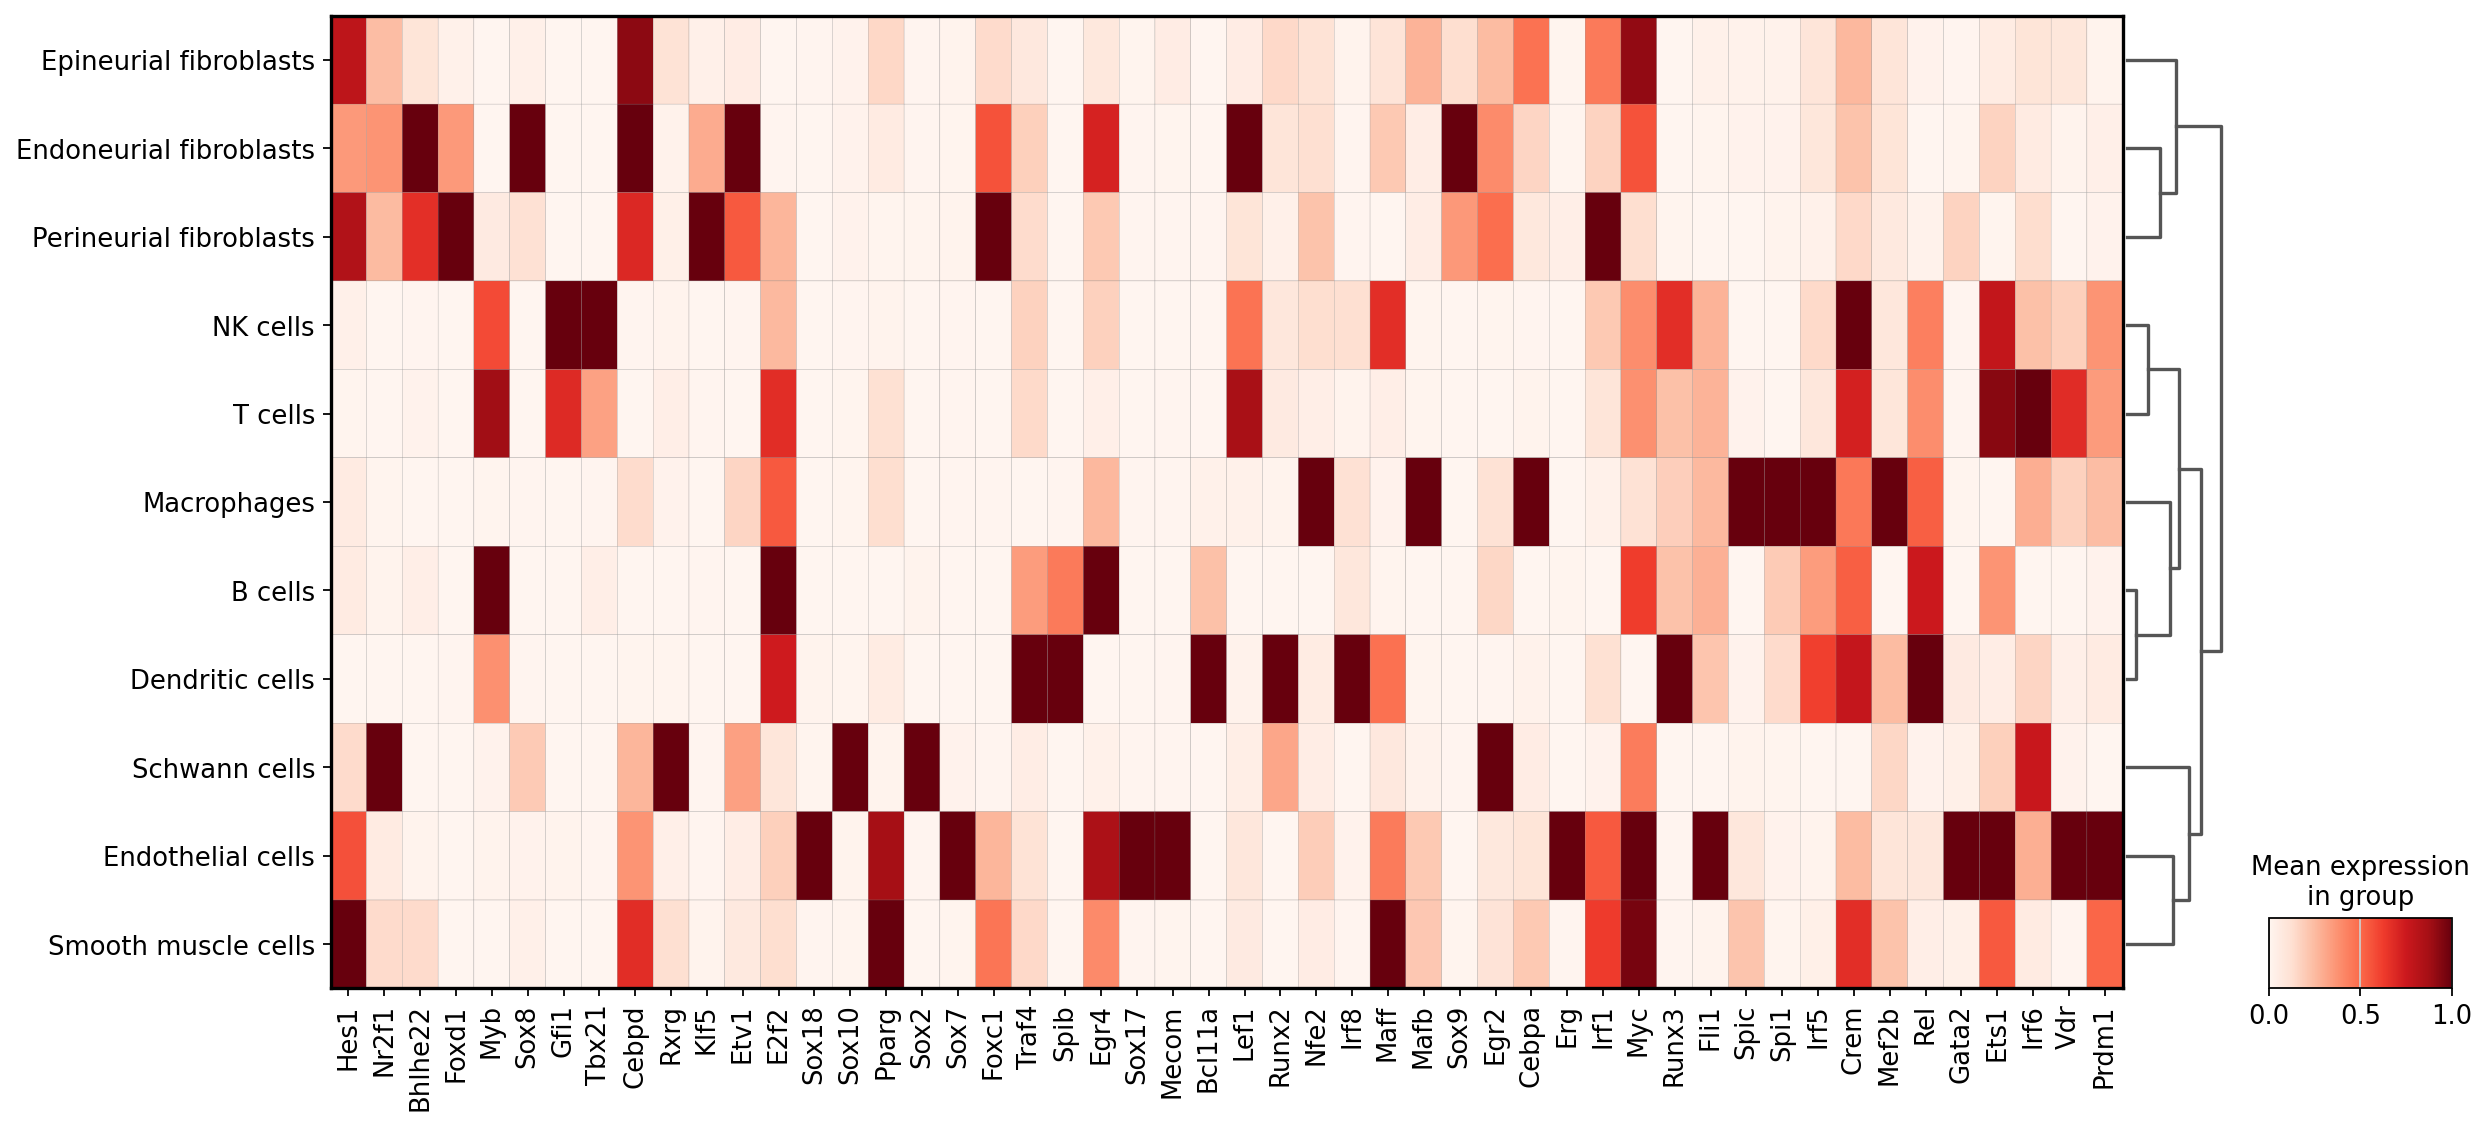

In [107]:
sc.pl.matrixplot(
    adata_batch_top_tfs,
    tf_names,
    groupby=ANNO_COL,
    cmap="Reds",
    log=True,
    dendrogram=True,
    standard_scale="var",
    # vmax = 2,
    figsize=[17, 8],
    # standard_scale="group",
    save="10-pyscenic-top_50-表达验证.pdf",
)